In [3]:
import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"


# Use qt backend for matplotlab to use interactive mne plots
%matplotlib qt

In [1]:
import mne
import pandas as pd
import tools.helpers
import os 
import numpy as np


from config import Config
configObj = Config()
configss = configObj.getConfigSnapshot()


In [3]:
# read the raw file
participant_id = 211
participant_name = 'P' + str(participant_id)
partipant_data_path =  participant_name + '/' + participant_name +'.gdf'
path = os.path.join(configss['root'], configss['data_dir'] , partipant_data_path ) 
print(path)
raw  = mne.io.read_raw_gdf(path, preload=True)

montage = tools.helpers.getMontage()

data_channels = [x for x in raw.ch_names if x not in 
                     configss['non_data_channels']]
if configss['target_channels'] is not None:
        data_channels = configss['target_channels']

raw = raw.pick(data_channels)

raw.set_montage(montage)

# add filtering


c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P211/P211.gdf
Extracting EDF parameters from c:\Users\erang\Desktop\Oddball\ov_experiment\scenarios\data\P211\P211.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
1Z, 2Z, 3Z, 4Z, 6Z, 7Z, 8Z, 9Z, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 1R, 2R, 3R, 4R, 5R, 6R, 7R, 8R, 9R, 10R, 11R, 1LA, 2LA, 3LA, 1LB, 2LB, 3LB, 4LB, 5LB, 1LC, 2LC, 3LC, 4LC, 5LC, 1LD, 2LD, 3LD, 4LD, 1RA, 2RA, 3RA, 1RB, 2RB, 3RB, 4RB, 5RB, 1RC, 2RC, 3RC, 4RC, 5RC, 1RD, 2RD, 3RD, 4RD, Tgt, SC
Creating raw.info structure...
Reading 0 ... 123071  =      0.000 ...   246.142 secs...


C:\Users\erang\AppData\Local\Temp\ipykernel_1880\1471751781.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,65 points
Good channels,62 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [4]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [5]:
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

In [6]:
ica = ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.7s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,38 iterations on raw data (123072 samples)
ICA components,15
Available PCA components,62
Channel types,eeg
ICA components marked for exclusion,—


In [7]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of eeg variance explained by all components: 0.978504661565891


In [8]:
explained_var_ratio = ica.get_explained_variance_ratio(
    filt_raw, components=[0], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by first component: 58%


Creating RawArray with float64 data, n_channels=15, n_times=123072
    Range : 0 ... 123071 =      0.000 ...   246.142 secs
Ready.
Using matplotlib as 2D backend.


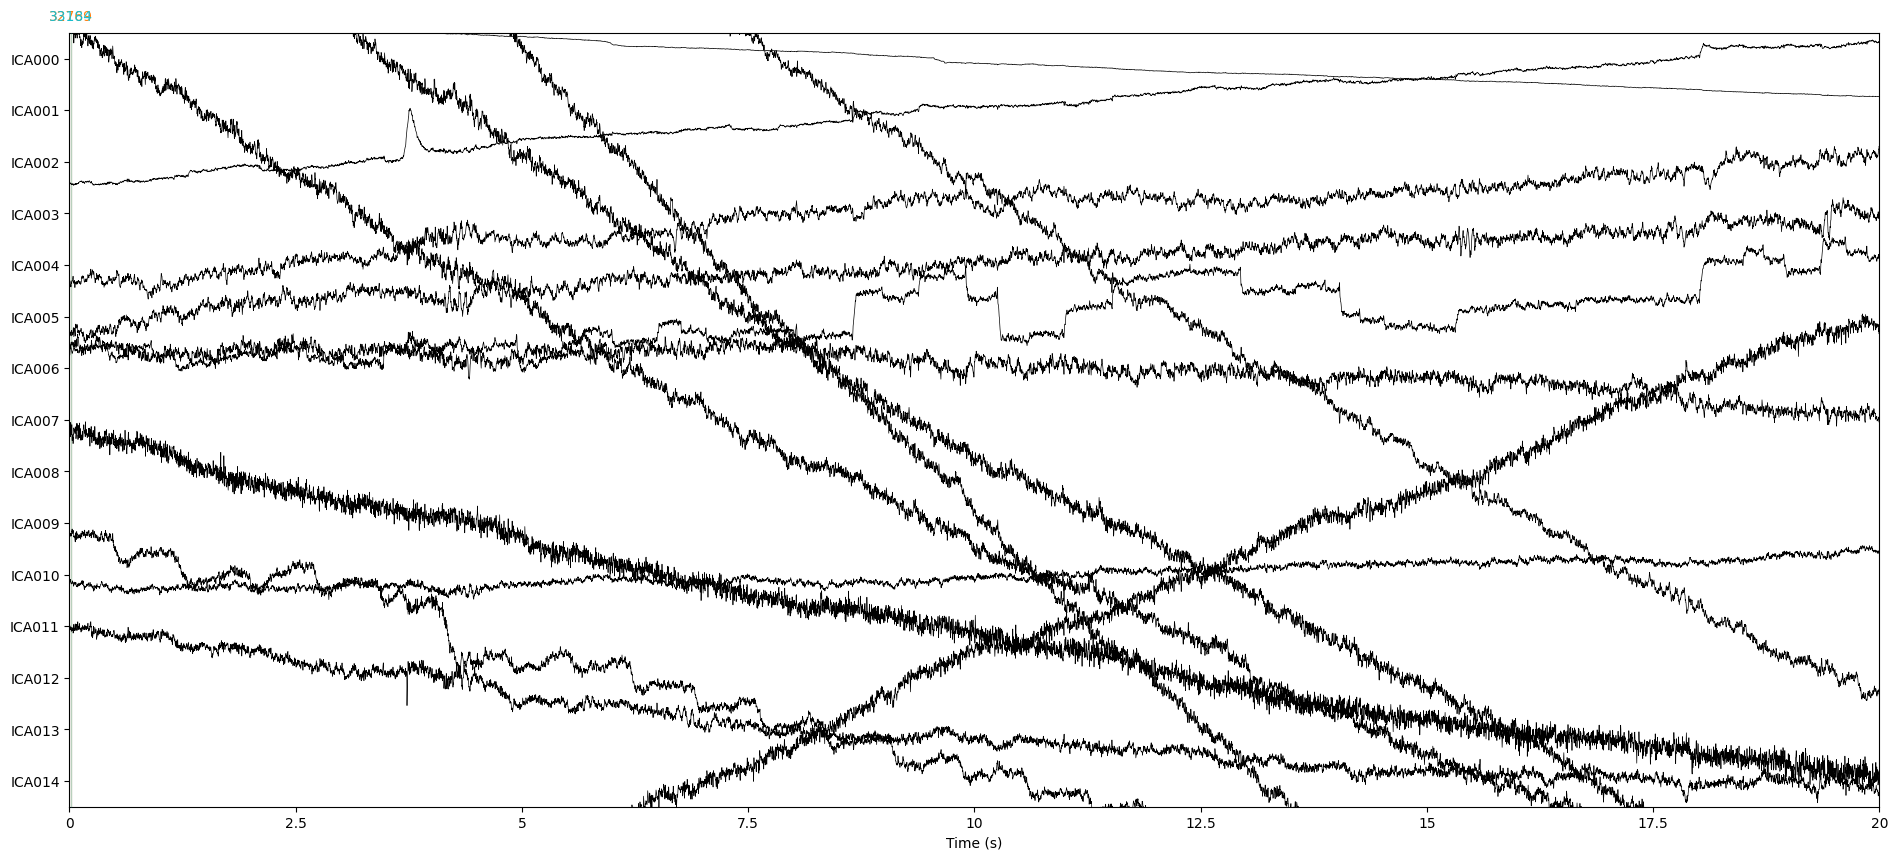

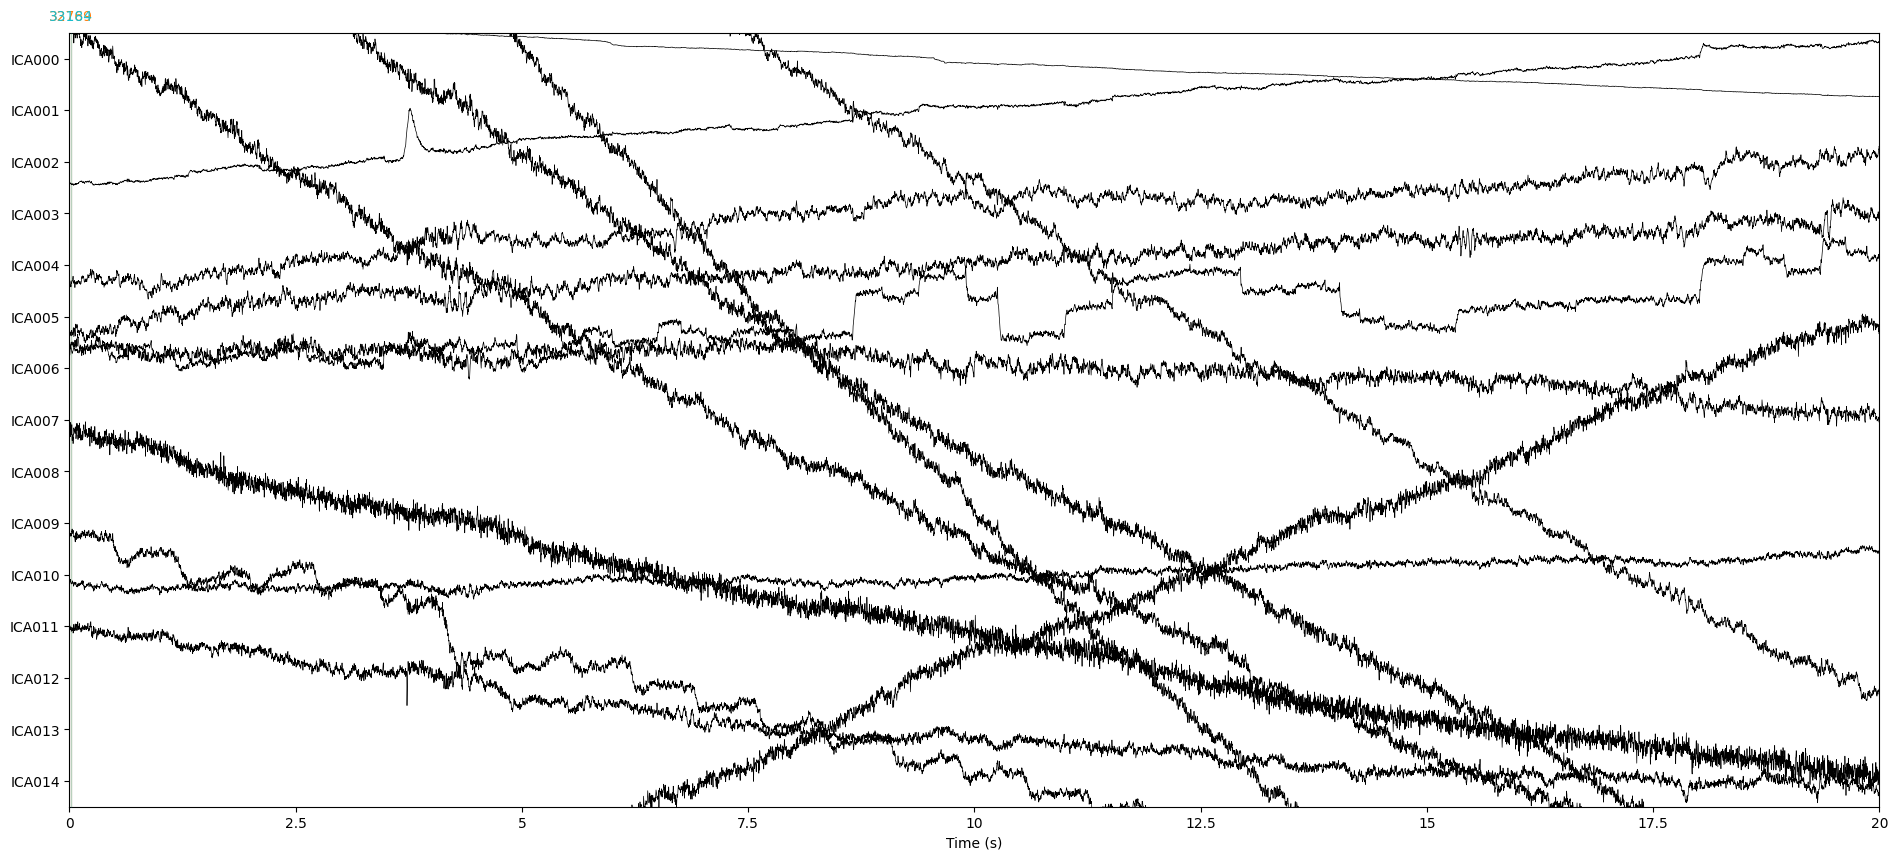

In [9]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

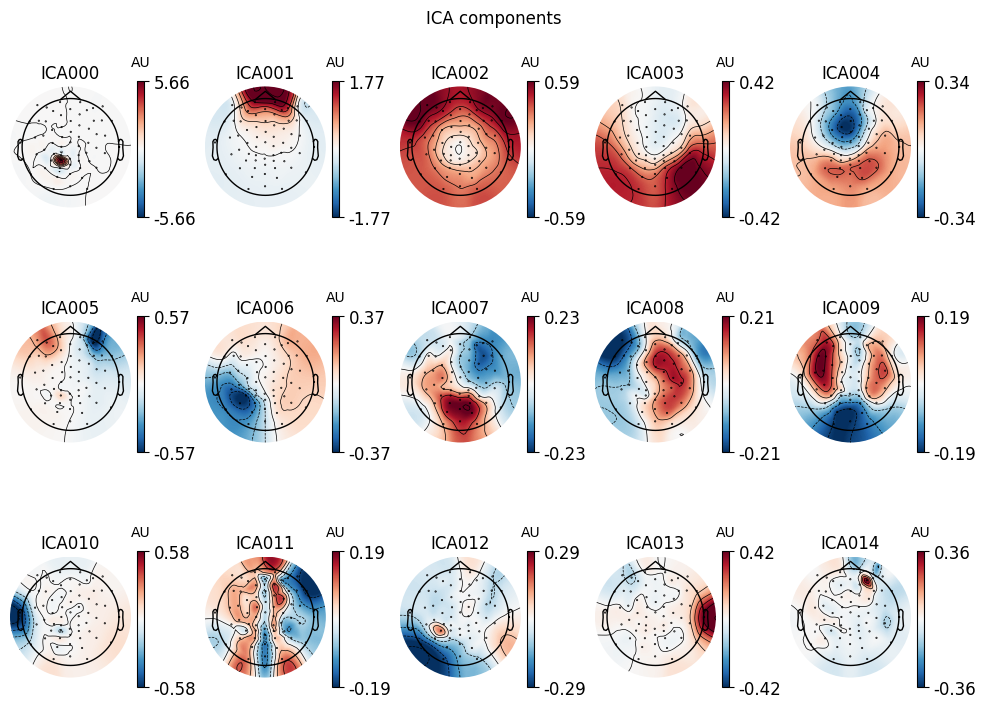

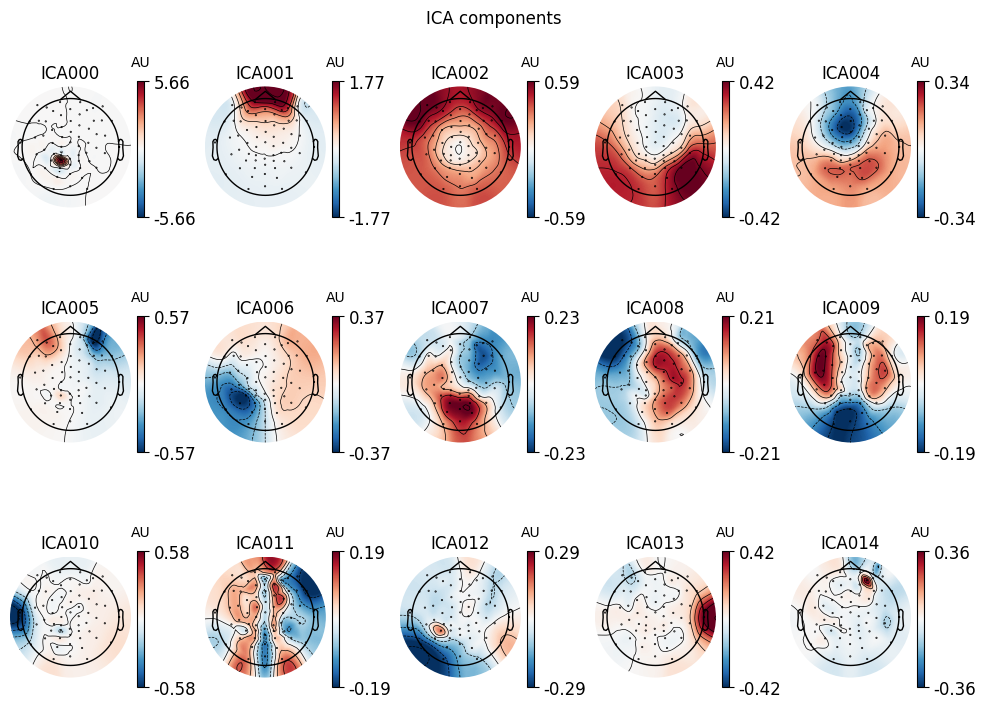

In [10]:
ica.plot_components(sphere=(0.00, -0.04, 0.00, 0.1255), colorbar=True, inst=filt_raw)

In [11]:
ica.exclude = []
num_excl = 0
max_ic = 2
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(filt_raw,
                                                ch_name=['1L', '1R', '2LC', '2RC'], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print('Final z threshold = ' + str(round(z_thresh, 2)))

Using EOG channels: 1L, 1R, 2LC, 2RC
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency

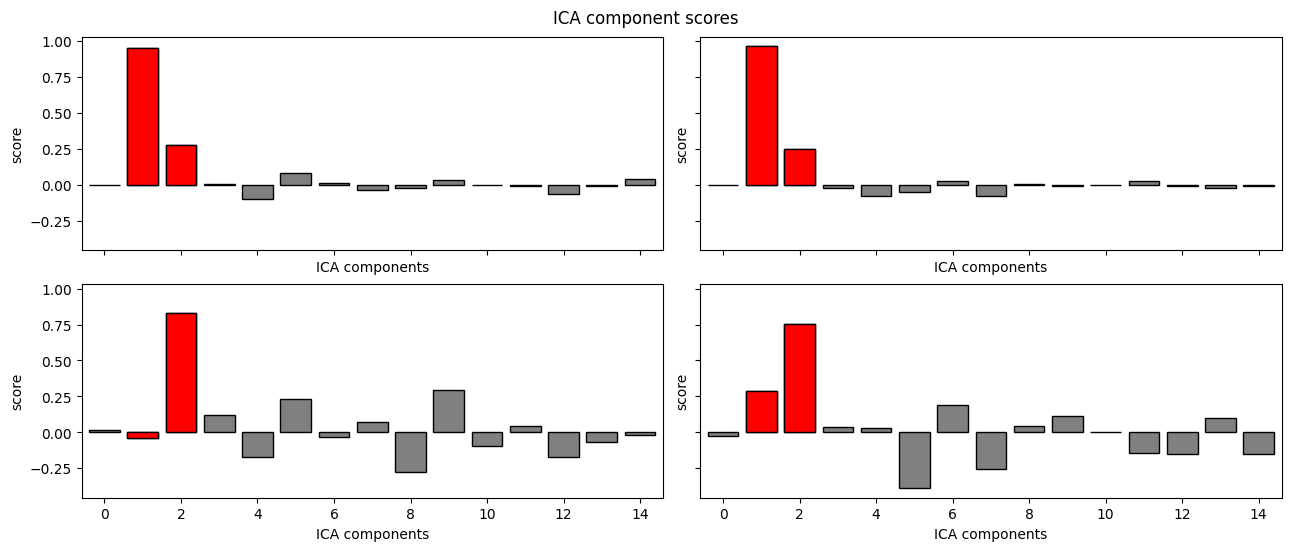

In [12]:
ica.plot_scores(eog_scores);

In [13]:
from mne.preprocessing import EOGRegression

C:\Users\erang\AppData\Local\Temp\ipykernel_1880\2353349493.py:1: RuntimeWarning: The locations of multiple reference channels are ignored.
  filt_raw = mne.add_reference_channels(raw, ref_channels=["5Z"])


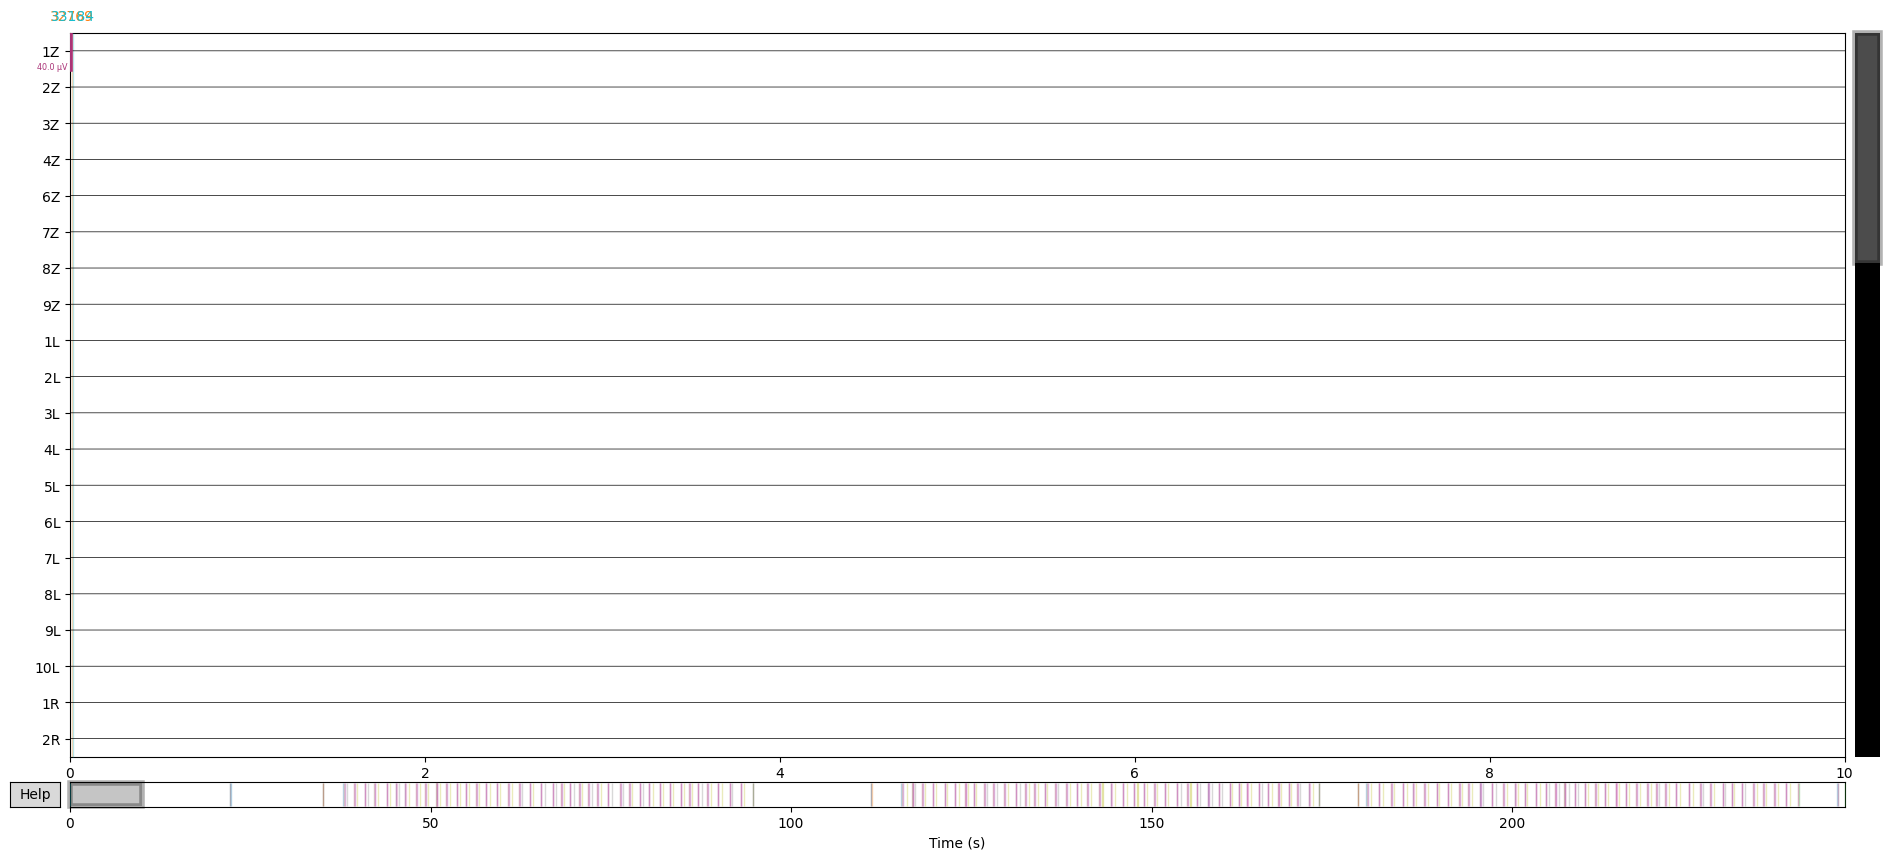

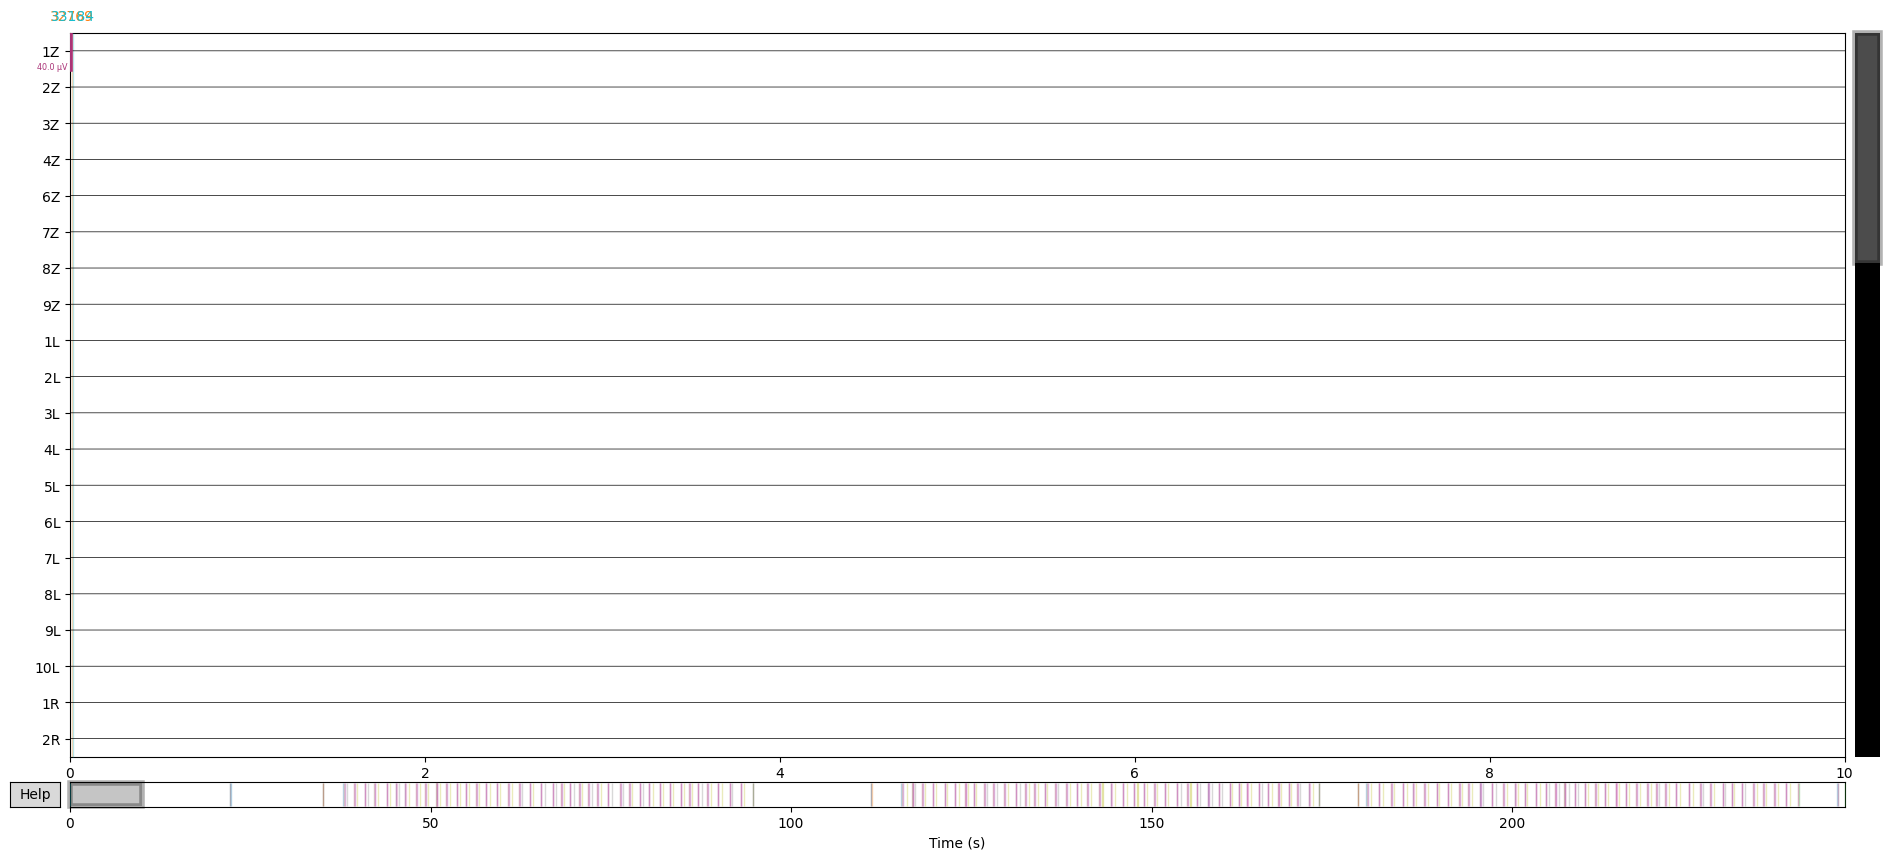

In [14]:
filt_raw = mne.add_reference_channels(raw, ref_channels=["5Z"])
filt_raw.plot()

In [15]:
# Fit the regression model
weights = EOGRegression().fit(filt_raw)
raw_clean = weights.apply(fi1lt_raw, copy=True)

# Show the filter weights in a topomap
weights.plot()

No projector specified for this dataset. Please consider the method self.add_proj.


ValueError: picks ('eog') could not be interpreted as channel names (no channel "['eog']"), channel types (no type "['eog']" present), or a generic type (just "all" or "data")

C:\Users\erang\AppData\Local\Temp\ipykernel_24832\366799786.py:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  fig1 = neonatal_montage.plot()


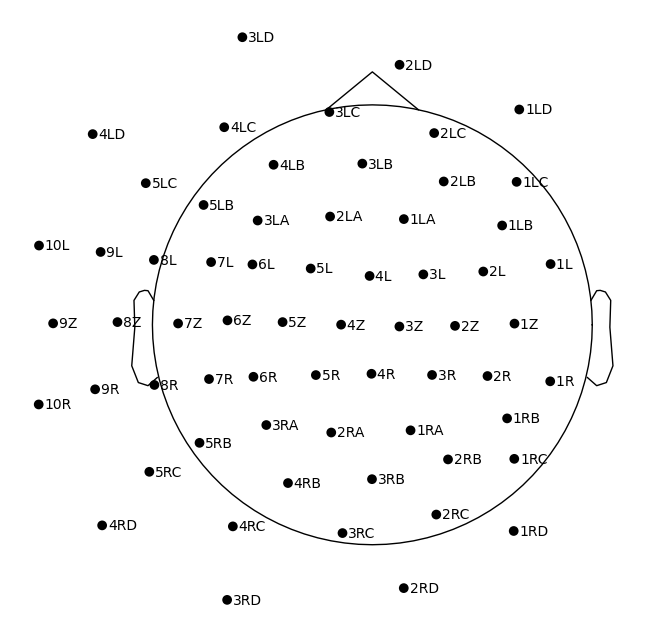

In [ ]:
fig1 = neonatal_montage.plot()  